In [14]:
# Import dependencies & libraries
from google.colab import files
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import linregress
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

In [2]:
# Upload file train.csv & test.csv sebelum menjalankan kode berikutnya
uploaded = files.upload()

Saving test.csv to test.csv
Saving train.csv to train.csv


In [3]:
# Fungsi u/: cleaning dataset
def clean_data(df):
    # Isi missing value pada kolom Popularity dengan mean
    df['Popularity'] = df['Popularity'].fillna(round(df['Popularity'].mean(), 1))

    # Hapus kolom dengan missing values
    cleaned_df = df.drop(["instrumentalness", "key"], axis=1)

    return cleaned_df

In [4]:
def normalize(df):
  # Inisialisasi object StandardScaler()
    scaler = StandardScaler()

    # Normalisasi langsung pada kolom bertipe float64
    df[df.select_dtypes(include=['float64']).columns] = scaler.fit_transform(df.select_dtypes(include=['float64']))

    return df


In [5]:
def df_to_tensor(df):
    # Konversi semua data numerik ke numpy array dan kemudian ke tensor
    df_tensor = torch.tensor(df.select_dtypes(include=['float64', 'int64']).values, dtype=torch.float32)

    return df_tensor

In [6]:
# Fungsi membagi train set menjadi train & validation set
def split_train_validation(df):
    # Memisahkan train_df menjadi train_data dan val_data (80% train, 20% validation)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Class'])

    # Menampilkan informasi jumlah data
    print("Jumlah data training:", len(train_df))
    print("Jumlah data validation:", len(val_df))

    return train_df, val_df

In [20]:
# Fungsi Training
def train_model(model, optimizer, train_loader, val_loader, epochs):
    history = {"loss": [], "val_acc": []}

    for ei in range(epochs):
      sum_loss = 0.0

      # Klasifikasi, SGD Step, perhitungan loss, & CrossEntropy pada data training
      for x, y in train_loader:
        optimizer.zero_grad()
        yt = model(x)
        loss = criterion(yt.float(), y.float())
        with torch.no_grad():
          sum_loss += loss
        loss.backward()
        optimizer.step()

      with torch.no_grad():
        ncorrect = 0
        avg_loss = sum_loss / Xtrain.shape[0]
        for x, y in val_loader:
          yt = model(x)
          # print(f'y={y}')
          # print(f'yt={yt}')
          lt = torch.argmax(yt, dim=1) # kelas hasil prediksi
          ll = torch.argmax(y, dim=1) # kelas hasil dari label
          # print(f'lt={lt}')
          # print(f'll={ll}')
          for i in range(lt.shape[0]):
            if ll[i] == lt[i]:
              ncorrect += 1

        avg_val_acc = ncorrect / Xval.shape[0] * 100.0

        # Save metrics
        history["loss"].append(avg_loss)
        history["val_acc"].append(avg_val_acc)

        print(f"Epoch {ei+1} | Loss: {avg_loss:.4f} | Val Acc: {avg_val_acc:.2f}%")

    return history

In [7]:

# Load data
train_df = pd.read_csv('train.csv')
test_df= pd.read_csv('test.csv')

# ----------------!!!-----------------------
# Hitung jumlah missing value per kolom
missing_values_train = train_df.isna().sum()

# Tampilkan jumlah missing value
print(missing_values_train)

# Jika ingin melihat hanya kolom yang memiliki missing value
missing_values_train = missing_values_train[missing_values_train > 0]
print("Kolom pada training set dengan missing values:")
print(missing_values_train)

# ----------------!!!-----------------------
# Hitung jumlah missing value per kolom
missing_values_test = test_df.isna().sum()

# Tampilkan jumlah missing value
print(missing_values_test)

# Jika ingin melihat hanya kolom yang memiliki missing value
missing_values_test = missing_values_test[missing_values_test > 0]
print("Kolom pada test set dengan missing values:")
print(missing_values_test)

# Bersihkan dataset
cleaned_train_df = clean_data(train_df)
cleaned_test_df = clean_data(test_df)

# Simpan dataset
cleaned_train_df.to_csv('train_cleaned.csv', index=False)
cleaned_test_df.to_csv('test_cleaned.csv', index=False)

# Normalisasi dataset
cleaned_trained_df = normalize(cleaned_train_df)
cleaned_test_df = normalize(cleaned_test_df)

# Bagi train set menjadi train & validation set
train_df, val_df = split_train_validation(cleaned_train_df)

# Tranformasi train, validation, & test set menjadi tensor
train_tensor = df_to_tensor(train_df)
val_tensor = df_to_tensor(val_df)
test_tensor = df_to_tensor(cleaned_test_df)

Artist Name              0
Track Name               0
Popularity             428
danceability             0
energy                   0
key                   2014
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      4377
liveness                 0
valence                  0
tempo                    0
duration_in min/ms       0
time_signature           0
Class                    0
dtype: int64
Kolom pada training set dengan missing values:
Popularity           428
key                 2014
instrumentalness    4377
dtype: int64
Artist Name              0
Track Name               0
Popularity             227
danceability             0
energy                   0
key                    808
loudness                 0
mode                     0
speechiness              0
acousticness             0
instrumentalness      1909
liveness                 0
valence                  0
tempo                    0
duration_in min

In [8]:
print(train_tensor)
print(val_tensor)
print(test_tensor)

tensor([[ 1.8869,  1.3868, -1.0655,  ..., -0.7500,  4.0000,  5.0000],
        [-1.4236, -0.1109,  0.5405,  ..., -0.2458,  4.0000, 10.0000],
        [-0.0297,  0.3763, -0.7978,  ..., -0.5143,  4.0000, 10.0000],
        ...,
        [ 0.6672, -0.0567, -0.2837,  ...,  0.1261,  4.0000,  5.0000],
        [-1.4236,  0.4304, -0.8403,  ..., -1.7926,  4.0000,  3.0000],
        [-0.3782,  2.2168,  0.3536,  ..., -0.6870,  4.0000,  5.0000]])
tensor([[-0.7848,  0.4966, -0.3559,  ..., -1.7925,  4.0000,  3.0000],
        [-0.9590,  0.0455, -0.9465,  ..., -0.3146,  4.0000,  6.0000],
        [ 0.3187, -0.0206,  1.2586,  ..., -0.0762,  4.0000,  8.0000],
        ...,
        [-0.4363,  0.1297, -0.5131,  ...,  2.8993,  4.0000, 10.0000],
        [-0.9590, -1.3859,  0.9654,  ...,  0.1420,  4.0000, 10.0000],
        [-0.3201, -0.1289,  1.2925,  ...,  0.6345,  4.0000,  8.0000]])
tensor([[ 1.6352e+00, -1.4440e+00, -1.1093e+00,  ...,  3.8704e-01,
          1.0486e+00,  4.0000e+00],
        [-6.3987e-01, -2.2505

In [9]:
# (Optional) download file csv yg sudah dibersihkan
files.download("train_cleaned.csv")
files.download("test_cleaned.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
# Definisi kelas Dataset
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X  # Fitur
        self.Y = Y  # Label/target

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Pisahkan fitur (X) dan label (Y)
Xtrain = train_tensor[:, :-1]
Ytrain = train_tensor[:, -1].long()

# Konversi Ytrain menjadi one-hot encoding
Ytrain = torch.nn.functional.one_hot(Ytrain, num_classes=len(torch.unique(Ytrain)))

Xval = val_tensor[:, :-1]
Yval = val_tensor[:, -1].long()

# Konversi Yval menjadi one-hot encoding
Yval = torch.nn.functional.one_hot(Yval, num_classes=len(torch.unique(Yval)))

Xtest = test_tensor[:, :-1]
Ytest = test_tensor[:, -1]

# Ytrain = train_df['Class']  # Kolom kelas sebagai target
# Xtrain = train_df.drop(columns=['Class'])  # Drop kolom kelas dari fitur

# Buat objek dataset
train_set = MyDataset(Xtrain, Ytrain)
val_set = MyDataset(Xval, Yval)
test_set = MyDataset(Xtest, Ytest)

In [11]:
# Gunakan DataLoader untuk batching
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)


In [24]:
 # Pembangunan Model
class MyModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(MyModel, self).__init__()
        self.layer1 = nn.Linear(input_size, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, output_size)

        # Inisialisasi bobot menggunakan He untuk layer 1-3
        nn.init.kaiming_normal_(self.layer1.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.layer2.weight, nonlinearity='relu')
        nn.init.kaiming_normal_(self.layer3.weight, nonlinearity='relu')

        # Inisialisasi bobot menggunakan Xavier untuk layer 4
        nn.init.xavier_normal_(self.layer4.weight)

        # Inisialisasi bias dengan nol
        nn.init.zeros_(self.layer1.bias)
        nn.init.zeros_(self.layer2.bias)
        nn.init.zeros_(self.layer3.bias)
        nn.init.zeros_(self.layer4.bias)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return torch.sigmoid(self.layer4(x)) # Output tanpa fungsi aktivasi, cocok untuk regresi

# print(len(torch.unique(Ytrain)))

# Inisialisasi model dan optimizer
model = MyModel(Xtrain.shape[1], Ytrain.shape[1])
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Inisialisasi loss function
criterion = nn.CrossEntropyLoss()

# Inisialisasi dua model: satu dengan L2 regularization dan satu tanpa
model_with_l2 = MyModel(Xtrain.shape[1], Ytrain.shape[1])
model_without_l2 = MyModel(Xtrain.shape[1], Ytrain.shape[1])

# Optimizer dengan dan tanpa L2 regularization
optimizer_with_l2 = optim.SGD(model_with_l2.parameters(), lr=0.001, weight_decay=1e-4)
optimizer_without_l2 = optim.SGD(model_without_l2.parameters(), lr=0.001)

In [25]:
# Training model tanpa L2 regularization
print("\nTraining model without L2 regularization:")
history_without_l2 = train_model(model_without_l2, optimizer_without_l2, train_loader, val_loader, epochs=100)


Training model without L2 regularization:
Epoch 1 | Loss: 0.0755 | Val Acc: 3.42%
Epoch 2 | Loss: 0.0748 | Val Acc: 6.64%
Epoch 3 | Loss: 0.0742 | Val Acc: 12.31%
Epoch 4 | Loss: 0.0736 | Val Acc: 17.67%
Epoch 5 | Loss: 0.0732 | Val Acc: 22.47%
Epoch 6 | Loss: 0.0726 | Val Acc: 24.89%
Epoch 7 | Loss: 0.0721 | Val Acc: 25.78%
Epoch 8 | Loss: 0.0714 | Val Acc: 25.75%
Epoch 9 | Loss: 0.0708 | Val Acc: 25.17%
Epoch 10 | Loss: 0.0701 | Val Acc: 25.14%
Epoch 11 | Loss: 0.0695 | Val Acc: 24.58%
Epoch 12 | Loss: 0.0689 | Val Acc: 24.61%
Epoch 13 | Loss: 0.0684 | Val Acc: 24.67%
Epoch 14 | Loss: 0.0680 | Val Acc: 24.64%
Epoch 15 | Loss: 0.0677 | Val Acc: 24.86%
Epoch 16 | Loss: 0.0674 | Val Acc: 24.81%
Epoch 17 | Loss: 0.0672 | Val Acc: 24.94%
Epoch 18 | Loss: 0.0670 | Val Acc: 24.94%
Epoch 19 | Loss: 0.0668 | Val Acc: 25.11%
Epoch 20 | Loss: 0.0667 | Val Acc: 25.14%
Epoch 21 | Loss: 0.0665 | Val Acc: 25.22%
Epoch 22 | Loss: 0.0664 | Val Acc: 25.53%
Epoch 23 | Loss: 0.0663 | Val Acc: 25.61%
Ep

In [26]:
# Training model dengan L2 regularization
print("Training model with L2 regularization:")
history_with_l2 = train_model(model_with_l2, optimizer_with_l2, train_loader, val_loader, epochs=100)

Training model with L2 regularization:
Epoch 1 | Loss: 0.0752 | Val Acc: 8.14%
Epoch 2 | Loss: 0.0738 | Val Acc: 14.22%
Epoch 3 | Loss: 0.0728 | Val Acc: 19.17%
Epoch 4 | Loss: 0.0720 | Val Acc: 22.50%
Epoch 5 | Loss: 0.0713 | Val Acc: 24.42%
Epoch 6 | Loss: 0.0708 | Val Acc: 26.36%
Epoch 7 | Loss: 0.0702 | Val Acc: 27.31%
Epoch 8 | Loss: 0.0698 | Val Acc: 27.47%
Epoch 9 | Loss: 0.0693 | Val Acc: 27.50%
Epoch 10 | Loss: 0.0690 | Val Acc: 27.50%
Epoch 11 | Loss: 0.0686 | Val Acc: 27.53%
Epoch 12 | Loss: 0.0684 | Val Acc: 27.67%
Epoch 13 | Loss: 0.0682 | Val Acc: 27.81%
Epoch 14 | Loss: 0.0680 | Val Acc: 27.97%
Epoch 15 | Loss: 0.0678 | Val Acc: 28.03%
Epoch 16 | Loss: 0.0676 | Val Acc: 28.08%
Epoch 17 | Loss: 0.0675 | Val Acc: 28.22%
Epoch 18 | Loss: 0.0674 | Val Acc: 28.36%
Epoch 19 | Loss: 0.0673 | Val Acc: 28.56%
Epoch 20 | Loss: 0.0671 | Val Acc: 28.69%
Epoch 21 | Loss: 0.0670 | Val Acc: 28.69%
Epoch 22 | Loss: 0.0669 | Val Acc: 28.78%
Epoch 23 | Loss: 0.0668 | Val Acc: 28.92%
Epoch

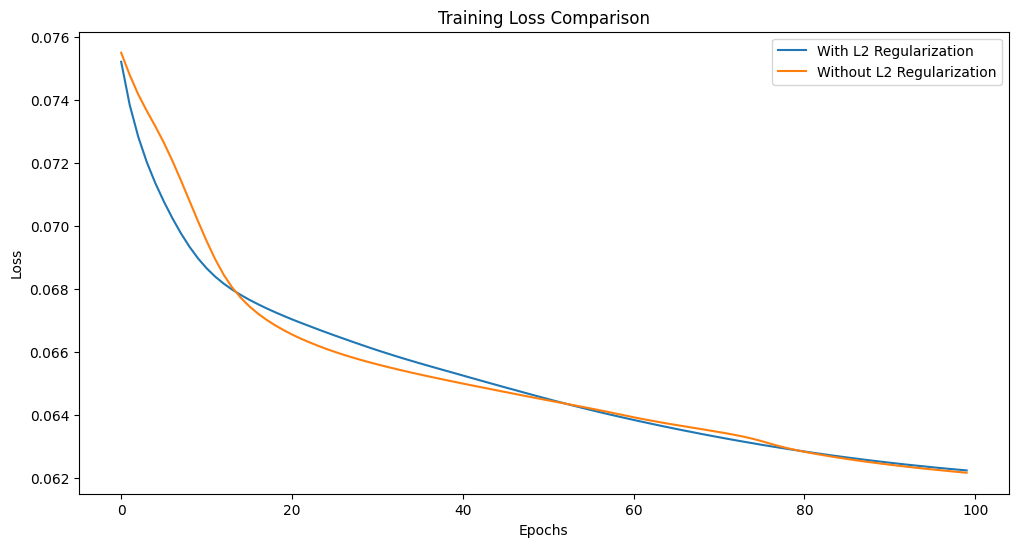

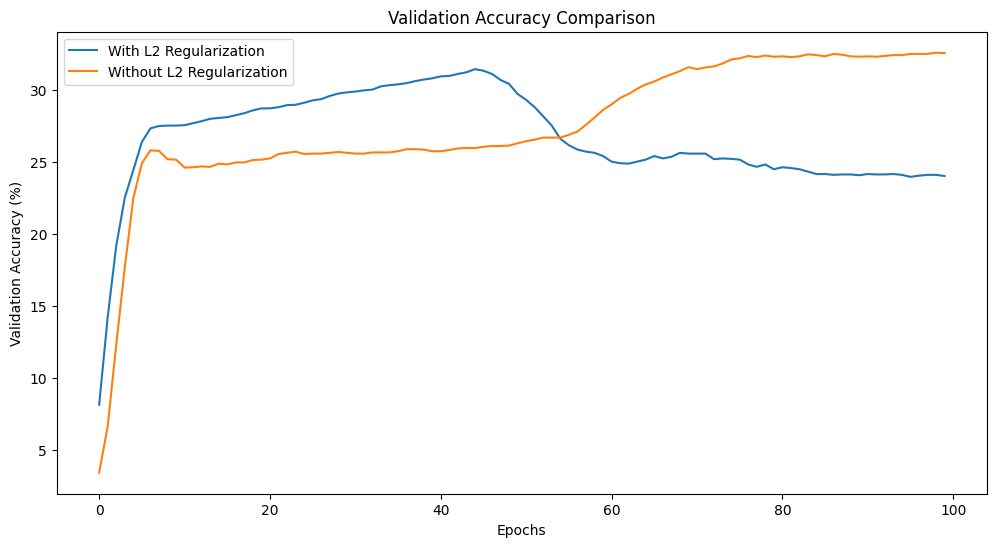

In [28]:
# Visualisasi Perbandingan Metrik

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history_with_l2["loss"], label="With L2 Regularization")
plt.plot(history_without_l2["loss"], label="Without L2 Regularization")
plt.title("Training Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Plot Validation Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history_with_l2["val_acc"], label="With L2 Regularization")
plt.plot(history_without_l2["val_acc"], label="Without L2 Regularization")
plt.title("Validation Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.legend()
plt.show()
